Step 1: Setup and Library Imports

In [11]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit-learn for machine learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Mount Google Drive to access your dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Step 2: Load and Preprocess the Dataset

In [12]:
# Define the path to your dataset in Google Drive
file_path = "/content/drive/MyDrive/WELFake_Dataset.csv"

# Load the dataset into a pandas DataFrame
print("Loading the dataset...")
df = pd.read_csv(file_path)
print("Dataset loaded successfully.")

# --- Data Cleaning ---
# Display initial dataset shape
print(f"Initial dataset shape: {df.shape}")

# Check for missing values in 'text' and 'label' columns
print(f"Missing values in 'text' column: {df['text'].isnull().sum()}")
print(f"Missing values in 'label' column: {df['label'].isnull().sum()}")

# Drop rows with missing 'text' or 'label' values
df.dropna(subset=['text', 'label'], inplace=True)
print(f"Shape after dropping missing values: {df.shape}")

# Check the distribution of labels (0 for REAL, 1 for FAKE)
print("\nLabel distribution:")
print(df['label'].value_counts())

Loading the dataset...
Dataset loaded successfully.
Initial dataset shape: (72134, 4)
Missing values in 'text' column: 39
Missing values in 'label' column: 0
Shape after dropping missing values: (72095, 4)

Label distribution:
label
1    37067
0    35028
Name: count, dtype: int64


Step 3: Split Data into Training and Testing Sets

In [13]:
# Define features (X) and target (y)
X = df['text']
y = df['label']

# Split the data into 80% training and 20% testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,    # 20% of data will be used for testing
    random_state=42,  # Ensures reproducibility
    stratify=y        # Maintains the same label distribution in train and test sets
)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

Training set size: 57676
Testing set size: 14419


Step 4: Feature Extraction with TF-IDF Vectorizer and feature engineering

In [14]:
# Initialize the TF-IDF Vectorizer
# - stop_words='english': Removes common English words (e.g., 'the', 'a', 'is')
# - max_df=0.7: Ignores words that appear in more than 70% of the documents
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)

# Fit the vectorizer on the training data and transform it
print("Vectorizing training data...")
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data using the already fitted vectorizer
print("Vectorizing testing data...")
tfidf_test = tfidf_vectorizer.transform(X_test)

print("Vectorization complete.")

Vectorizing training data...
Vectorizing testing data...
Vectorization complete.


Step 5:Exploratory Data Analysis (EDA)

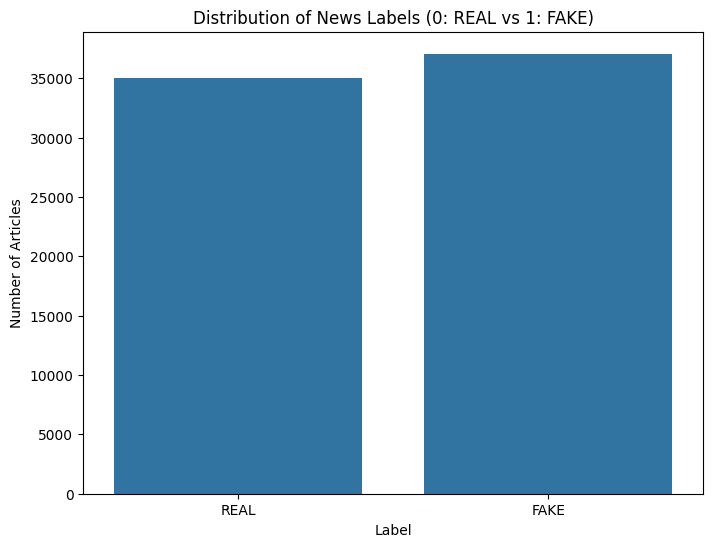

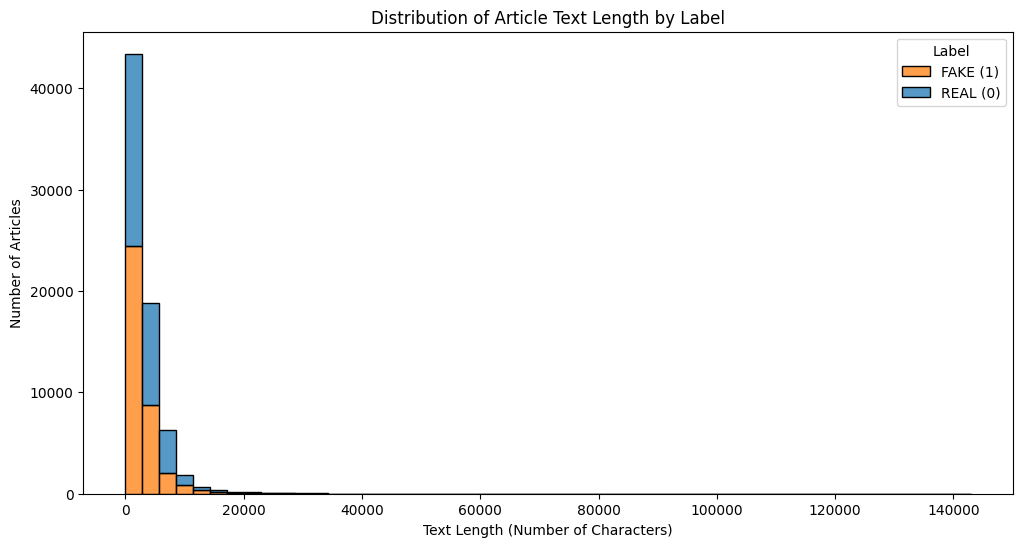

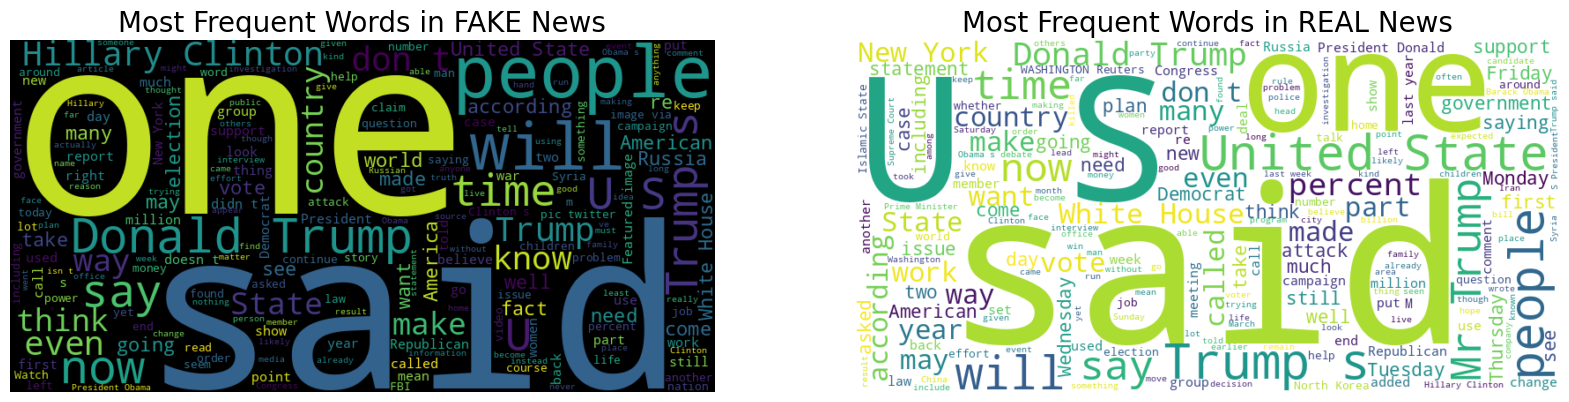

In [19]:
# --- EDA Visuals ---

# 1. Label Distribution
# This shows if the dataset is balanced between REAL and FAKE news.
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df)
plt.title('Distribution of News Labels (0: REAL vs 1: FAKE)')
plt.xlabel('Label')
plt.ylabel('Number of Articles')
plt.xticks([0, 1], ['REAL', 'FAKE'])
plt.show()

# 2. Text Length Distribution
# This helps us see if there's a difference in length between real and fake articles.
df['text_length'] = df['text'].apply(len)

plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='text_length', hue='label', multiple='stack', bins=50)
plt.title('Distribution of Article Text Length by Label')
plt.xlabel('Text Length (Number of Characters)')
plt.ylabel('Number of Articles')
plt.legend(title='Label', labels=['FAKE (1)', 'REAL (0)'])
plt.show()

# 3. Word Clouds
# This visualizes the most frequent words in each category.
from wordcloud import WordCloud

# Word Cloud for FAKE News (label = 1)
fake_news_text = ' '.join(df[df['label'] == 1]['text'])
wordcloud_fake = WordCloud(width=800, height=400, background_color='black').generate(fake_news_text)

# Word Cloud for REAL News (label = 0)
real_news_text = ' '.join(df[df['label'] == 0]['text'])
wordcloud_real = WordCloud(width=800, height=400, background_color='white').generate(real_news_text)

# Display the Word Clouds
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.imshow(wordcloud_fake, interpolation='bilinear')
ax1.set_title('Most Frequent Words in FAKE News', fontsize=20)
ax1.axis('off')

ax2.imshow(wordcloud_real, interpolation='bilinear')
ax2.set_title('Most Frequent Words in REAL News', fontsize=20)
ax2.axis('off')

plt.show()

Step 6: Baseline SVM Model Training & Evaluation

Training the baseline LinearSVC model...
Baseline model training complete.

Baseline Model Test Accuracy: 95.95%

Baseline Model Classification Report:
              precision    recall  f1-score   support

    REAL (0)       0.97      0.95      0.96      7006
    FAKE (1)       0.95      0.97      0.96      7413

    accuracy                           0.96     14419
   macro avg       0.96      0.96      0.96     14419
weighted avg       0.96      0.96      0.96     14419


Baseline Model Confusion Matrix:


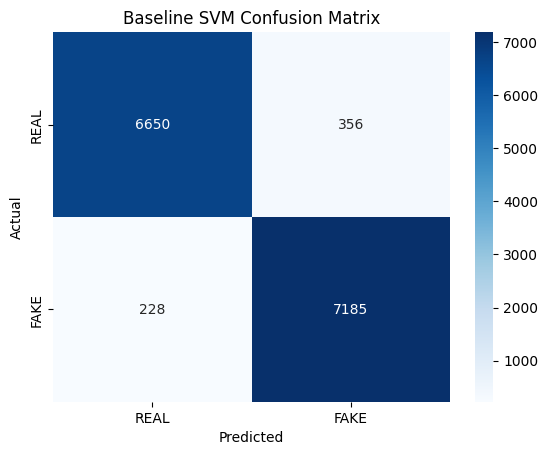

In [15]:
# --- Baseline Model ---
# Initialize and train the LinearSVC model
print("Training the baseline LinearSVC model...")
baseline_svm = LinearSVC(random_state=42, tol=1e-5)
baseline_svm.fit(tfidf_train, y_train)
print("Baseline model training complete.")

# Make predictions on the test set
y_pred = baseline_svm.predict(tfidf_test)

# --- Evaluate the Baseline Model ---
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nBaseline Model Test Accuracy: {accuracy * 100:.2f}%")

# Display the classification report (Precision, Recall, F1-Score)
print("\nBaseline Model Classification Report:")
print(classification_report(y_test, y_pred, target_names=['REAL (0)', 'FAKE (1)']))

# Display the confusion matrix
print("\nBaseline Model Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['REAL', 'FAKE'], yticklabels=['REAL', 'FAKE'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Baseline SVM Confusion Matrix')
plt.show()

Step 7: Hyperparameter Tuning with GridSearchCV

In [16]:
# --- Tuned Model with GridSearchCV ---
print("Starting hyperparameter tuning with GridSearchCV...")

# Define the parameter grid to search
# We are testing different values for the regularization parameter 'C'
param_grid = {
    'C': [0.1, 1, 10],
}

# Initialize GridSearchCV
# - cv=3: Uses 3-fold cross-validation
# - n_jobs=-1: Uses all available CPU cores to speed up the process
grid_search = GridSearchCV(
    LinearSVC(random_state=42, tol=1e-5),
    param_grid,
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Fit GridSearchCV to the training data
grid_search.fit(tfidf_train, y_train)

# Get the best model found by the search
best_svm = grid_search.best_estimator_

print("\nHyperparameter tuning complete.")
print(f"Best parameters found: {grid_search.best_params_}")

Starting hyperparameter tuning with GridSearchCV...
Fitting 3 folds for each of 3 candidates, totalling 9 fits

Hyperparameter tuning complete.
Best parameters found: {'C': 1}


Step 8: Final Evaluation of the Tuned Model


Tuned Model Test Accuracy: 95.95%

Tuned Model Classification Report:
              precision    recall  f1-score   support

    REAL (0)       0.97      0.95      0.96      7006
    FAKE (1)       0.95      0.97      0.96      7413

    accuracy                           0.96     14419
   macro avg       0.96      0.96      0.96     14419
weighted avg       0.96      0.96      0.96     14419


Tuned Model Confusion Matrix:


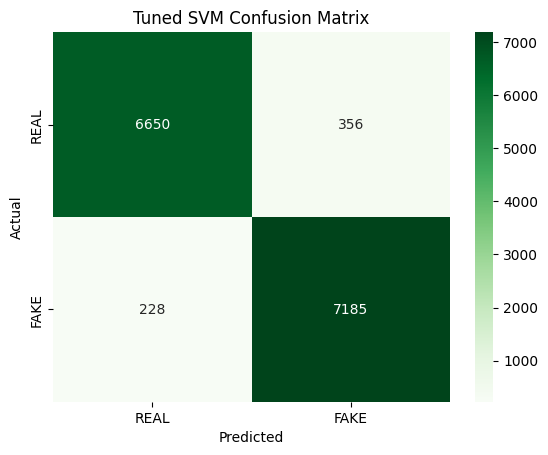

In [17]:
# Make predictions with the best model
y_pred_tuned = best_svm.predict(tfidf_test)

# --- Evaluate the Tuned Model ---
# Calculate accuracy
tuned_accuracy = accuracy_score(y_test, y_pred_tuned)
print(f"\nTuned Model Test Accuracy: {tuned_accuracy * 100:.2f}%")

# Display the classification report
print("\nTuned Model Classification Report:")
print(classification_report(y_test, y_pred_tuned, target_names=['REAL (0)', 'FAKE (1)']))

# Display the confusion matrix for the tuned model
print("\nTuned Model Confusion Matrix:")
cm_tuned = confusion_matrix(y_test, y_pred_tuned)
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Greens', xticklabels=['REAL', 'FAKE'], yticklabels=['REAL', 'FAKE'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Tuned SVM Confusion Matrix')
plt.show()

Step 9: Predicting on New News Articles

In [18]:
# Store the best model as our final model
final_model = best_svm

# Example news articles for testing (more similar to the training dataset)
news_articles = [
    # Example 1 (Should be REAL - has a journalistic, political style)
    "WASHINGTON (Reuters) - The White House commented today that the proposed infrastructure bill is a top priority for the administration, aiming to secure bipartisan support before the upcoming congressional recess.",

    # Example 2 (Should be FAKE - uses sensational language)
    "A secret document has been leaked showing a global conspiracy to control the weather, and every world leader is in on it. This is the story the media won't tell you!"
]

# Transform the new articles using the TF-IDF vectorizer
news_vectors = tfidf_vectorizer.transform(news_articles)

# Predict the labels
predictions = final_model.predict(news_vectors)

# Print the results
print("\n--- Predictions on New Articles ---")
for article, pred in zip(news_articles, predictions):
    label = "REAL News" if pred == 0 else "FAKE News"
    print(f"\nArticle: '{article[:70]}...'")
    print(f"Prediction: **{label}**")


--- Predictions on New Articles ---

Article: 'WASHINGTON (Reuters) - The White House commented today that the propos...'
Prediction: **REAL News**

Article: 'A secret document has been leaked showing a global conspiracy to contr...'
Prediction: **FAKE News**
